In [24]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import cm, colors
import matplotlib.colors
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
from scipy.stats import linregress
import random
import geopandas as gpd

%config InlineBackend.figure_format = 'retina'

In [2]:
# parameters
focal_year = 2020
#github_logo_color = "#23292f"
#github_activity_light = "#9be9a8"
#github_activity_dark = "#216e39"
github_activity_NA = "#ebedef"

**Figure 1 -- ECI_software overview**

In [3]:
# data -- ECI_software
cdf = pd.read_csv("../outputs/eci_software_2020_2023.csv", sep=";")
cdf = cdf[cdf["year"]==focal_year]
ubiquity_order = cdf[["language", "ubiquity"]].drop_duplicates().sort_values(by="ubiquity", ascending=False)["language"].to_list()

# data -- world map
cmap = gpd.read_file("../data/world-administrative-boundaries.geojson")
cmap = cmap[["iso3", "iso_3166_1_alpha_2_codes", "name", "geometry"]].rename(columns={"iso_3166_1_alpha_2_codes" : "iso2"})

In [4]:
def mcp_matrix(df, key_columns, heatmap, custom_colors, labels, fontsize, ax=None):
    table = df[key_columns]
    table = pd.pivot_table(table,
        values=key_columns[2],
        index=key_columns[0],
        columns=key_columns[1],
        aggfunc="sum",
        margins=True,
        margins_name='total')
    
    table = table\
        .sort_values(by=["total"], ascending=False, axis=0)\
        .sort_values(by=["total"], ascending=False, axis=1)

    table = table.drop(["total"], axis=1).drop(["total"], axis=0)

    if heatmap==False:
        return table
    else:
        if ax is None:
            ax = plt.gca()
        #custom_colors = ["#ffffff", "#08306b"]
        custom_cmap = mcolors.ListedColormap(custom_colors)
        sns.heatmap(table, cbar=False, cmap=custom_cmap, ax=ax)
        ax.set_title(labels[0], size=fontsize)
        ax.set_xlabel(labels[1], size=fontsize)
        ax.set_ylabel(labels[2], size=fontsize)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        ax.tick_params(left = False, bottom = False)
        
# mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, custom_colors=["#ffffff", "#08306b"], labels=["Software", "Country", "Language"], fontsize=20)

In [5]:
# mcp trade / technology / research
trade_cdf = pd.read_csv("../outputs/trade_cdf_2020.csv", sep=";")
patent_cdf = pd.read_csv("../outputs/patent_cdf_2020.csv", sep=";")
research_cdf = pd.read_csv("../outputs/research_cdf_2020.csv", sep=";")

#mcp_matrix(trade_cdf, key_columns=["product", "iso2_code", "mcp"], heatmap=False, labels=["Trade", "Country", "Product category"], fontsize=20)
#mcp_matrix(patent_cdf, key_columns=["class", "iso2_code", "mcp"], heatmap=True, labels=["Technology", "Country", "Patent class"], fontsize=20)
#mcp_matrix(research_cdf, key_columns=["category", "iso2_code", "mcp"], heatmap=True, labels=["Research", "Country", "Subject category"], fontsize=20)

In [16]:
def map_complexity(geodf, c_column, fontsize, ax=None):
    if ax is None:
        ax = plt.gca()

    # create common colormap
    cvals  = [geodf[c_column].min(), geodf[c_column].max()]
    colors = ["#08306b","#ffffff"]
    #colors = ["#ffffff","#08306b"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
    nan_color = github_activity_NA
    cmap.set_bad(color=nan_color)

    geodf.plot(column=c_column, cmap=cmap, edgecolor="None", ax=ax, missing_kwds={"color": nan_color})

    # add boundaries
    geodf.boundary.plot(color="lightgrey", linewidth=0.125, ax=ax)

    # create colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01, aspect=30, shrink=0.55, orientation="vertical") # horizontal
    
    # define colorbar ticks
    tick_positions = [1, 50, 100, 150, 175]
    cbar.set_ticks(tick_positions)

    # set the tick labels, replacing the last one with "NA"
    tick_labels = [1, 50, 100, 150, "NA"]
    cbar.ax.hlines(list(range(151, 176)), *cbar.ax.get_xlim(), color=github_activity_NA)
    cbar.ax.yaxis.set_tick_params(pad=5, width=0.8)
    cbar.ax.set_yticklabels(tick_labels)
    cbar.ax.invert_yaxis()

    cbar.set_label("ECI (software) ranking", rotation=90, labelpad=12, fontsize=fontsize)
    ax.axis('off')

In [7]:
cmap2 = pd.merge(
    cmap,
    cdf[["iso2_code", "eci"]].drop_duplicates(),
    left_on="iso2",
    right_on="iso2_code",
    how="left"
)
cmap2["eci_software_rank"] = cmap2["eci"].rank(ascending=False)

#map_complexity(cmap2, c_column="eci_software_rank", fontsize=20)

In [8]:
def normalize_column_to_range(table, column_name):
    min_val = table[column_name].min()
    max_val = table[column_name].max()
    table[column_name] = 2 * (table[column_name] - min_val) / (max_val - min_val) - 1
    return table


In [9]:
# data from code/01_data_prep_complexity.ipynb	
df = pd.read_csv("../outputs/eci_comparisons_2020.csv", sep=";")

# filter for developer counts or missing values
df2 = df[["iso2_code", "software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]]\
    .dropna()\
    .drop_duplicates()\
    .reset_index(drop=True)

df2 = pd.merge(
    df2,
    cmap[["iso2", "iso3"]].drop_duplicates(),
    left_on="iso2_code",
    right_on="iso2",
    how="left"
)

df2 = normalize_column_to_range(df2, "software_eci_2020")
df2 = normalize_column_to_range(df2, "trade_eci_2020")
df2 = normalize_column_to_range(df2, "tech_eci_2020")
df2 = normalize_column_to_range(df2, "research_eci_2020")

In [10]:
def eci_correlation_plot(df, selected_countries, key_variables, xlabel, ylabel, fontsize, ax=None):
    if ax is None:
        ax = plt.gca()

    # highlighting the selected countries
    color_dict = {1: "#08306b", 0: "#B4C0D2"}
    df["group_color"] = df["iso2_code"].isin(selected_countries).astype(int)

    # scatter plots
    sns.scatterplot(
        x=key_variables[0],
        y=key_variables[1],
        data=df[df["group_color"] == 0],
        hue=df["group_color"][df["group_color"] == 0],
        palette=color_dict,
        legend=False,
        ax=ax,
        zorder=5
    )
    sns.scatterplot(
        x=key_variables[0],
        y=key_variables[1],
        data=df[df["group_color"] == 1],
        hue=df["group_color"][df["group_color"] == 1],
        palette=color_dict,
        legend=False,
        ax=ax,
        zorder=6
    )    
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color="lightgrey",zorder=2)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[key_variables[0]], df[key_variables[1]])
    r_squared = r_value ** 2
    print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   ", key_variables[0], "  ", key_variables[1])
    ax.set_xlabel(xlabel, size=fontsize)
    ax.set_ylabel(ylabel, size=fontsize)
    ax.tick_params("x", labelsize=(fontsize-3))
    ax.tick_params("y", labelsize=(fontsize-3))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0.015, tight=True)
    #ax.set_ylim(-1.4, 2.4)
    
    # add labels to selected countries
    for index, row in df.iterrows():
        if row["iso2_code"] in selected_countries:
            ax.text(row[key_variables[0]] + 0.05, row[key_variables[1]] + 0.05, row["iso3"], fontsize=fontsize-3, zorder=5)
   

#eci_correlation_plot(df2, key_variables=["trade_eci_2020", "software_eci_2020"], xlabel=True, ylabel="ECI (trade)")

In [11]:
selected_countries = ["US", "RU", "CL"]

def lollipop_eci(df, selected_iso2, x_categories, y_values, c_code, fontsize, ylabel, xticks, title_text, ax=None):
    df = df[df["iso2_code"]==selected_iso2]
    df = df.set_index(x_categories).reindex(ubiquity_order).reset_index()

    if ax is None:
        ax = plt.gca()
    
    color_dict = {1: "#08306b", 0: "#B4C0D2"}
    df["color_col"] = df["mcp"].map(color_dict)
    ax.scatter(df[x_categories], df[y_values], color=df["color_col"], s=15, zorder=4)
    ax.vlines(df[x_categories], ymin=0, ymax=df[y_values], colors=github_activity_NA)
    
    if ylabel==True:
        ax.set_xlabel("Languages", size=fontsize)
    ax.set_ylabel("RCA", size=fontsize)

    if xticks==True:
        ax.tick_params("x", labelsize=(fontsize-10), rotation=90)
    else:
        ax.set_xticklabels("")
    
    ax.tick_params("y", labelsize=(fontsize))
    ax.margins(0.0125, tight=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 5.65)
    ax.set_title(title_text, size=fontsize, loc="right")

#fig, ax = plt.subplots(1,1, figsize=(12,4))
#lollipop_eci(cdf, selected_iso2=selected_countries[2], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="Chile", ax=ax[8])

R2 0.597 p-value 0.0     trade_eci_2020    software_eci_2020
R2 0.606 p-value 0.0     tech_eci_2020    software_eci_2020
R2 0.523 p-value 0.0     research_eci_2020    software_eci_2020


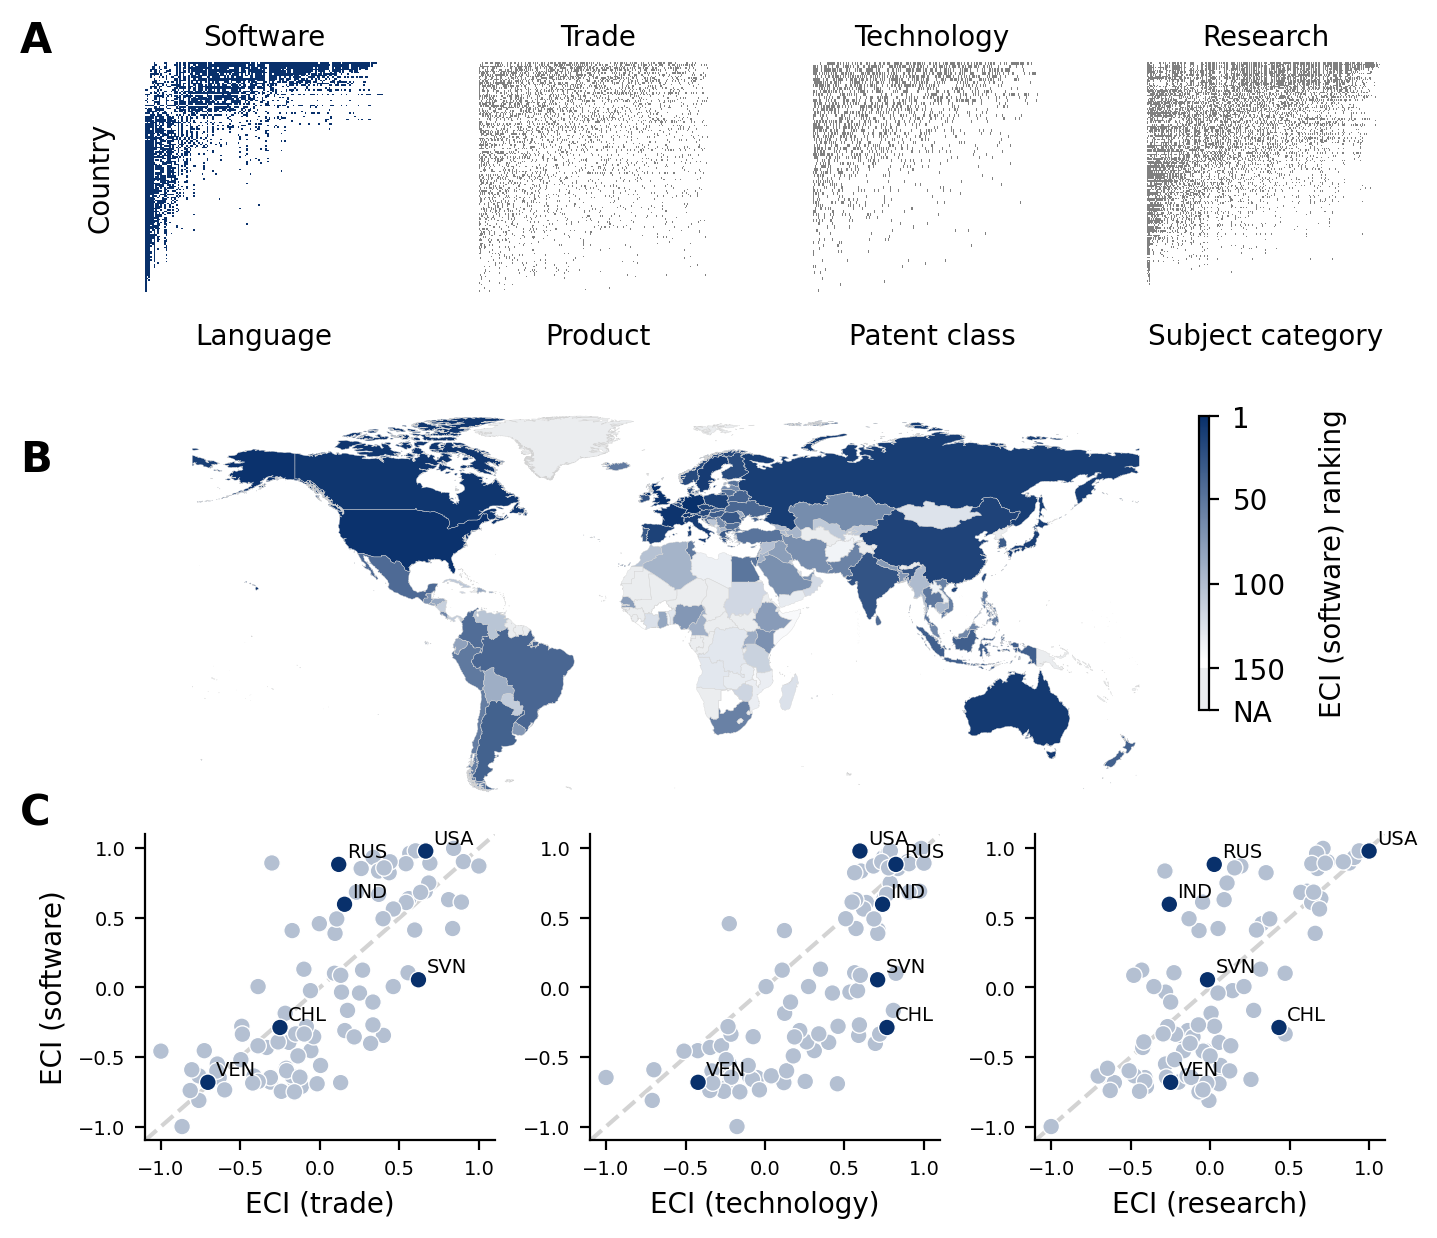

In [18]:
#selected_countries = ["US", "RU", "CL"]
#selected_countries = ["US", "RU", "CL", "AU", "IN", "CN"]
selected_countries = ["US", "RU", "CL", "IN", "VE", "SI"]
fontsize=10
fig = plt.figure(figsize=(8,7))

ax = [0]*8
gs = GridSpec(3,12, figure=fig, height_ratios=[1.5, 3.5, 2], hspace=0.01, wspace=6) #, height_ratios=[0.7, 0.7, 0.7, 2, 0.7, 0.7, 0.7], width_ratios=[1, 1, 1, 1, 1, 1], hspace=1.1, wspace=0.85)

ax[0] = fig.add_subplot(gs[0,0:3])
ax[1] = fig.add_subplot(gs[0,3:6])
ax[2] = fig.add_subplot(gs[0,6:9])
ax[3] = fig.add_subplot(gs[0,9:12])
ax[4] = fig.add_subplot(gs[1,0:12])
ax[5] = fig.add_subplot(gs[2,0:4])
ax[6] = fig.add_subplot(gs[2,4:8])
ax[7] = fig.add_subplot(gs[2,8:12])


# A
mcp_matrix(cdf, key_columns=["iso2_code", "language", "mcp"], heatmap=True, custom_colors=["#ffffff", "#08306b"], labels=["Software", "Language", "Country"], fontsize=fontsize, ax=ax[0])

# B
mcp_matrix(trade_cdf, key_columns=["iso2_code", "product", "mcp"], heatmap=True, custom_colors=["#ffffff", "#808080"], labels=["Trade", "Product", ""], fontsize=fontsize, ax=ax[1])

# C
mcp_matrix(patent_cdf, key_columns=["iso2_code", "class", "mcp"], heatmap=True, custom_colors=["#ffffff", "#808080"], labels=["Technology", "Patent class", ""], fontsize=fontsize, ax=ax[2])

# D
mcp_matrix(research_cdf, key_columns=["iso2_code", "category", "mcp"], heatmap=True, custom_colors=["#ffffff", "#808080"], labels=["Research", "Subject category", ""], fontsize=fontsize, ax=ax[3])

# E -- complexity map
map_complexity(cmap2, c_column="eci_software_rank", fontsize=fontsize, ax=ax[4])
ax[4].set_ylim(-57,115)

# F
eci_correlation_plot(df2, selected_countries=selected_countries, key_variables=["trade_eci_2020", "software_eci_2020"], xlabel="ECI (trade)", ylabel="ECI (software)", fontsize=fontsize, ax=ax[5])
#ax[5].set_xlim(-2.1,2.1)
ax[5].set_xlim(-1.1,1.1)
ax[5].set_ylim(-1.1,1.1)

# G
eci_correlation_plot(df2, selected_countries=selected_countries, key_variables=["tech_eci_2020", "software_eci_2020"], xlabel="ECI (technology)", ylabel="", fontsize=fontsize, ax=ax[6])
#ax[6].set_xlim(-2.9,2.1)
ax[6].set_xlim(-1.1,1.1)
ax[6].set_ylim(-1.1,1.1)

# H
eci_correlation_plot(df2, selected_countries=selected_countries, key_variables=["research_eci_2020", "software_eci_2020"], xlabel="ECI (research)", ylabel="", fontsize=fontsize, ax=ax[7])
#ax[7].set_xlim(-2.5,2.8)
ax[7].set_xlim(-1.1,1.1)
ax[7].set_ylim(-1.1,1.1)

# save 
#ax[0].annotate("A", xy=(0,1), xycoords='axes fraction', xytext=(-125,10), textcoords='offset pixels', weight='bold', size=fontsize+5)
#ax[4].annotate("B", xy=(0,1), xycoords='axes fraction', xytext=(-125,-140), textcoords='offset pixels', weight='bold', size=fontsize+5)
#ax[5].annotate("C", xy=(0,1), xycoords='axes fraction', xytext=(-125,10), textcoords='offset pixels', weight='bold', size=fontsize+5)
#plt.savefig("../figures/figure1_combined.png", bbox_inches='tight', dpi=300, facecolor="white")

#ax[0].annotate("A", xy=(0,1), xycoords='axes fraction', xytext=(-30,5), textcoords='offset pixels', weight='bold', size=fontsize+5)
#ax[4].annotate("B", xy=(0,1), xycoords='axes fraction', xytext=(-30,-30), textcoords='offset pixels', weight='bold', size=fontsize+5)
#ax[5].annotate("C", xy=(0,1), xycoords='axes fraction', xytext=(-30,5), textcoords='offset pixels', weight='bold', size=fontsize+5)
#plt.savefig("../figures/figure1_combined.pdf", bbox_inches='tight', dpi=300, facecolor="white")

# plt.savefig("../figures/figure1_combined.svg", bbox_inches='tight', dpi=300, facecolor="white")

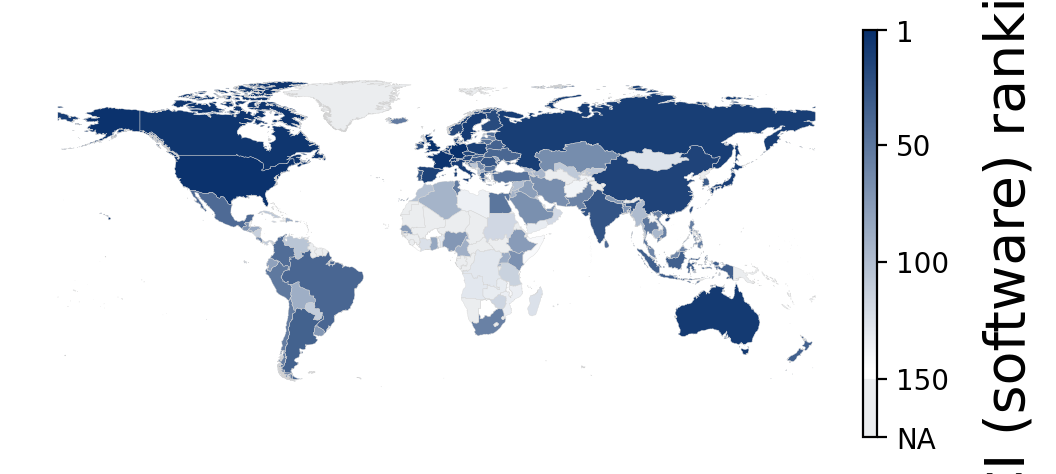

In [63]:
def map_complexity(geodf, c_column, fontsize, ax=None):
    if ax is None:
        ax = plt.gca()

    # create common colormap
    cvals  = [geodf[c_column].min(), geodf[c_column].max()]
    colors = ["#08306b","#ffffff"]
    #colors = ["#ffffff","#08306b"]
    norm=plt.Normalize(min(cvals),max(cvals))
    tuples = list(zip(map(norm,cvals), colors))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", tuples)
    nan_color = github_activity_NA
    cmap.set_bad(color=nan_color)

    geodf.plot(column=c_column, cmap=cmap, edgecolor="None", ax=ax, missing_kwds={"color": nan_color})

    # add boundaries
    geodf.boundary.plot(color="lightgrey", linewidth=0.125, ax=ax)

    # create colorbar
    #cmap = cmap.reversed()
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01, aspect=30, shrink=0.55, orientation="vertical") # horizontal
    
    # define colorbar ticks
    tick_positions = [1, 50, 100, 150] + [175]
    tick_labels = [str(int(pos)) for pos in tick_positions[:-1]] + ['NA']
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels(tick_labels)
    cbar.ax.invert_yaxis()
    
    # Fill the colorbar between 150-160 with the NA color
    cbar.ax.hlines(list(range(151, 176)), *cbar.ax.get_xlim(), color=github_activity_NA)


    cbar.set_label("ECI (software) ranking", rotation=90, labelpad=12, fontsize=fontsize)
    ax.axis('off')
    
cmap2 = pd.merge(
    cmap,
    cdf[["iso2_code", "eci"]].drop_duplicates(),
    left_on="iso2",
    right_on="iso2_code",
    how="left"
)
cmap2["eci_software_rank"] = cmap2["eci"].rank(ascending=False)

map_complexity(cmap2, c_column="eci_software_rank", fontsize=20)

In [434]:
df2[df2["iso2_code"]=="IN"]

,iso2_code,software_eci_2020,trade_eci_2020,tech_eci_2020,research_eci_2020,iso2,iso3,group_color
40,IN,0.584749,0.15522,0.739477,-0.256784,IN,IND,1


R2 0.596 p-value 0.0     trade_eci_2020    software_eci_2020
R2 0.606 p-value 0.0     tech_eci_2020    software_eci_2020
R2 0.519 p-value 0.0     research_eci_2020    software_eci_2020


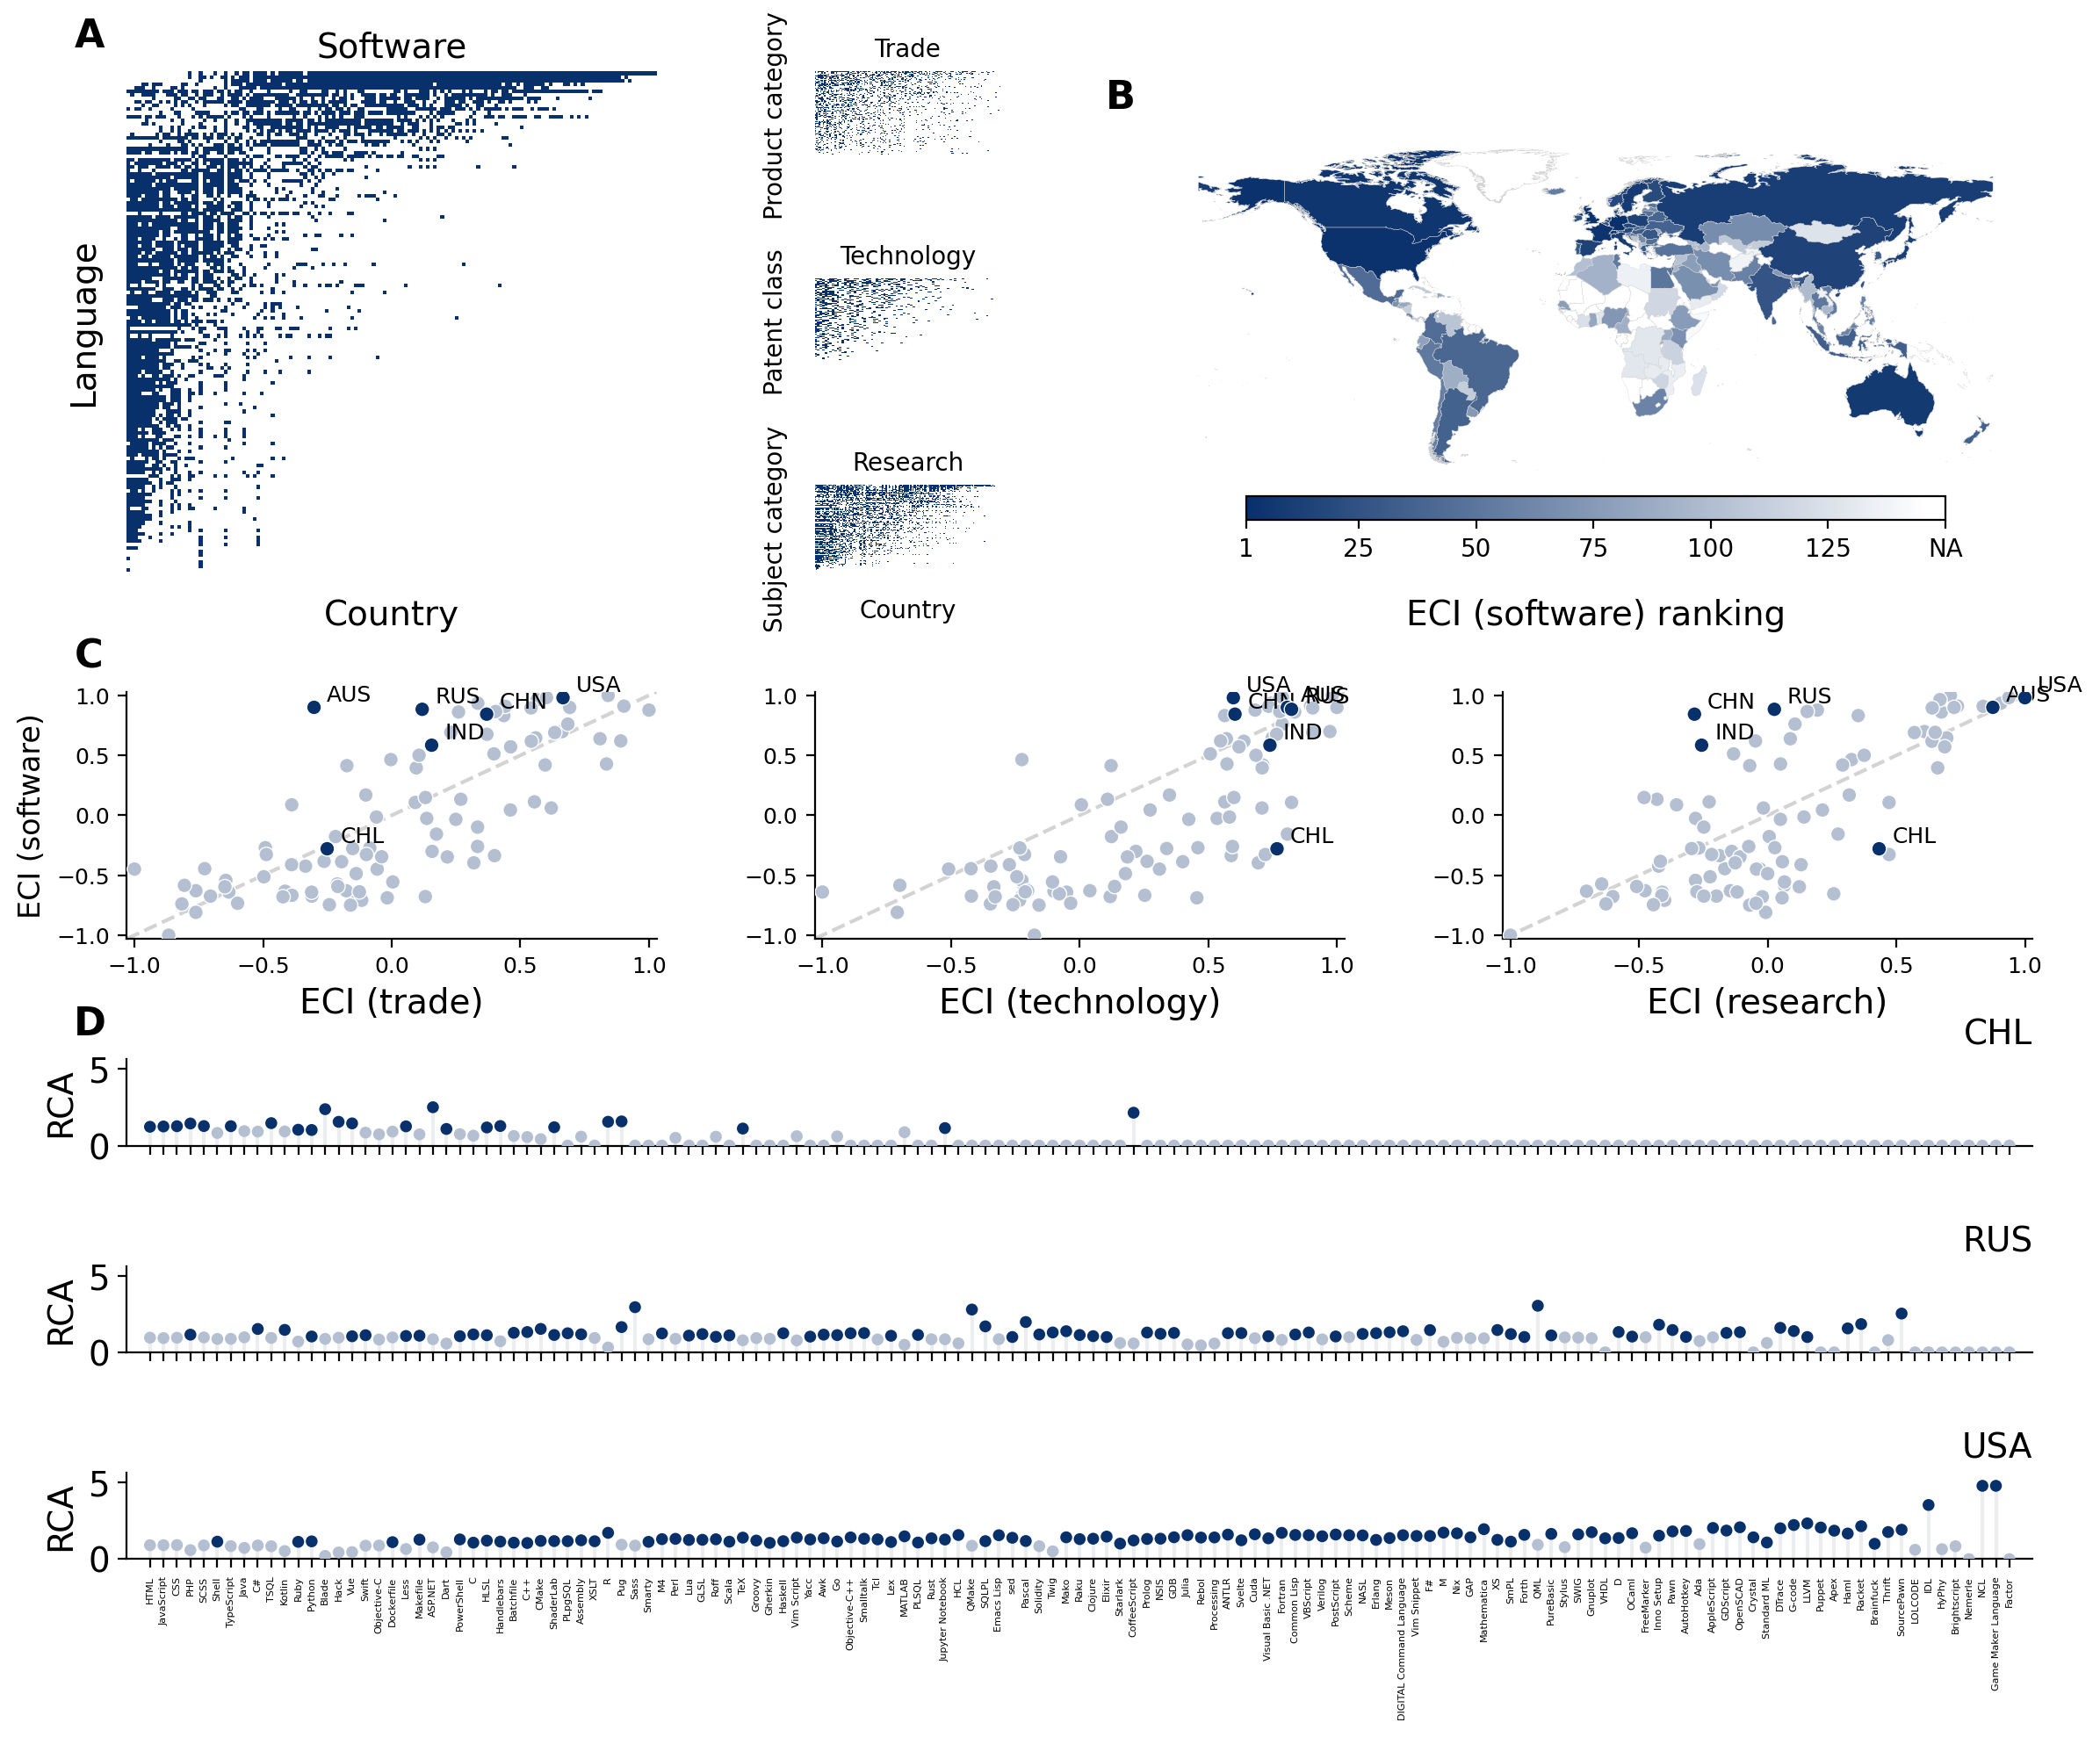

In [15]:
#selected_countries = ["US", "RU", "CL"]
selected_countries = ["US", "RU", "CL", "AU", "IN", "CN"]
fontsize=14
fig = plt.figure(figsize=(14,11))

ax = [0]*11
gs = GridSpec(7,6, figure=fig, height_ratios=[0.7, 0.7, 0.7, 2, 0.7, 0.7, 0.7], width_ratios=[1, 1, 1, 1, 1, 1], hspace=1.1, wspace=0.85)
ax[0] = fig.add_subplot(gs[0:3,0:2])
ax[1] = fig.add_subplot(gs[0,2])
ax[2] = fig.add_subplot(gs[1,2])
ax[3] = fig.add_subplot(gs[2,2])
ax[4] = fig.add_subplot(gs[0:3,3:6])

ax[5] = fig.add_subplot(gs[3,0:2])
ax[6] = fig.add_subplot(gs[3,2:4])
ax[7] = fig.add_subplot(gs[3,4:6])

ax[8] = fig.add_subplot(gs[4,0:])
ax[9] = fig.add_subplot(gs[5,0:])
ax[10] = fig.add_subplot(gs[6,0:])


# A -- M_software
mcp_matrix(cdf, key_columns=["language", "iso2_code", "mcp"], heatmap=True, labels=["Software", "Country", "Language"], fontsize=fontsize, ax=ax[0])

# B
mcp_matrix(trade_cdf, key_columns=["product", "iso2_code", "mcp"], heatmap=True, labels=["Trade", "", "Product category"], fontsize=fontsize-4, ax=ax[1])

# C
mcp_matrix(patent_cdf, key_columns=["class", "iso2_code", "mcp"], heatmap=True, labels=["Technology", "", "Patent class"], fontsize=fontsize-4, ax=ax[2])

# D
mcp_matrix(research_cdf, key_columns=["category", "iso2_code", "mcp"], heatmap=True, labels=["Research", "Country", "Subject category"], fontsize=fontsize-4, ax=ax[3])

# E -- complexity map
map_complexity(cmap2, c_column="eci_software_rank", fontsize=fontsize, ax=ax[4])

# F
eci_correlation_plot(df2, selected_countries=selected_countries, key_variables=["trade_eci_2020", "software_eci_2020"], xlabel="ECI (trade)", ylabel="ECI (software)", fontsize=fontsize, ax=ax[5])
#ax[5].set_xlim(-2.1,2.1)

# G
eci_correlation_plot(df2, selected_countries=selected_countries, key_variables=["tech_eci_2020", "software_eci_2020"], xlabel="ECI (technology)", ylabel="", fontsize=fontsize, ax=ax[6])
#ax[6].set_xlim(-2.9,2.1)

# H
eci_correlation_plot(df2, selected_countries=selected_countries, key_variables=["research_eci_2020", "software_eci_2020"], xlabel="ECI (research)", ylabel="", fontsize=fontsize, ax=ax[7])
#ax[7].set_xlim(-2.5,2.8)

# I -- example country 1
lollipop_eci(cdf, selected_iso2=selected_countries[2], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="CHL", ax=ax[8])

# J -- example country 2
lollipop_eci(cdf, selected_iso2=selected_countries[1], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=False, title_text="RUS", ax=ax[9])

# K -- example country 3
lollipop_eci(cdf, selected_iso2=selected_countries[0], x_categories="language", y_values="rca", c_code="Green", fontsize=fontsize, ylabel=False, xticks=True, title_text="USA", ax=ax[10])

for a, label in zip(ax, ["A", "", "", "", "B", "C", "", "", "D", "", "", "", "", "", "", ""]):
    a.annotate(label.upper(), xy=(0,1), xycoords='axes fraction', xytext=(-60,28), textcoords='offset pixels', weight='bold', size=fontsize+2)

#plt.savefig("../figures/figure1_combined.svg", bbox_inches='tight', facecolor="white")
#plt.savefig("../figures/figure1_combined.png", bbox_inches='tight', facecolor="white")

In [37]:
### ENTRY example
# Check Republic -- ruby, python
# China -- many languages! Erlang (teleco mass pattern detection), visual basic, pascal, ...
# AU -- FreeMarker
# US -- FreeMarker, QMake, Sass
# France -- R
# GB -- QMake, Jupyter Notebook, ASP.NET
# Israel -- Lua
# Russia -- Mathematica, Ada, GAP, SCSS
# Estonia -- python


### EXIT example
# Chile -- tex, ruby, less
# USA -- Brainfuck
# India -- Handlebars, M, SMPL
# Russia -- many languages!
# Slovenia -- Javascript
# Latvia LV -- Kotlin
# Chine -- Pure Basic

**example search**

In [22]:
en_df = pd.read_csv("../outputs/data_entry_regressions_0011.csv", sep=";")

In [23]:
en_df[(en_df["entry01"]==1) & (en_df["language"]=="Rust")]

,iso2_code,language,entry01,consider00,pci,ubiquity,rca01,density
1229,RO,Rust,1,0,2.066526,25.0,1.0,0.375863


In [35]:
#en_df[(en_df["entry01"]==1) & (en_df["density"]>0.3) & (en_df["iso2_code"]=="US")]
en_df[(en_df["entry01"]==1) & (en_df["iso2_code"]=="CN")]

,iso2_code,language,entry01,consider00,pci,ubiquity,rca01,density
319,CN,Erlang,1,0,2.287610,15.0,1.0,0.397268
322,CN,GLSL,1,0,1.972092,29.0,1.0,0.450530
324,CN,Gnuplot,1,0,2.578767,12.0,1.0,0.415920
330,CN,Inno Setup,1,0,2.588067,12.0,1.0,0.409844
336,CN,Meson,1,0,2.466396,15.0,1.0,0.419712
340,CN,Pascal,1,0,2.162532,21.0,1.0,0.429883
353,CN,VHDL,1,0,2.140631,12.0,1.0,0.416377
354,CN,Visual Basic .NET,1,0,1.747127,16.0,1.0,0.379736


In [54]:
en_df[(en_df["entry01"]==1) & (en_df["density"]>0.2)].head(50)

,iso2_code,language,entry01,consider00,pci,ubiquity,rca01,density
60,AT,Ruby,1,0,-0.804169,56.0,1.0,0.391997
67,AU,FreeMarker,1,0,1.976589,12.0,1.0,0.709203
121,BE,Ruby,1,0,-0.804169,56.0,1.0,0.460906
124,BE,Vue,1,0,-0.590525,48.0,1.0,0.498540
127,BG,Dockerfile,1,0,0.963375,45.0,1.0,0.203372
251,CA,Cuda,1,0,2.274234,16.0,1.0,0.800497
253,CA,FreeMarker,1,0,1.976589,12.0,1.0,0.767607
254,CA,Gherkin,1,0,1.671451,27.0,1.0,0.788523
255,CA,Go,1,0,1.287478,26.0,1.0,0.776748
265,CA,QMake,1,0,1.674847,23.0,1.0,0.778138


<Axes: >

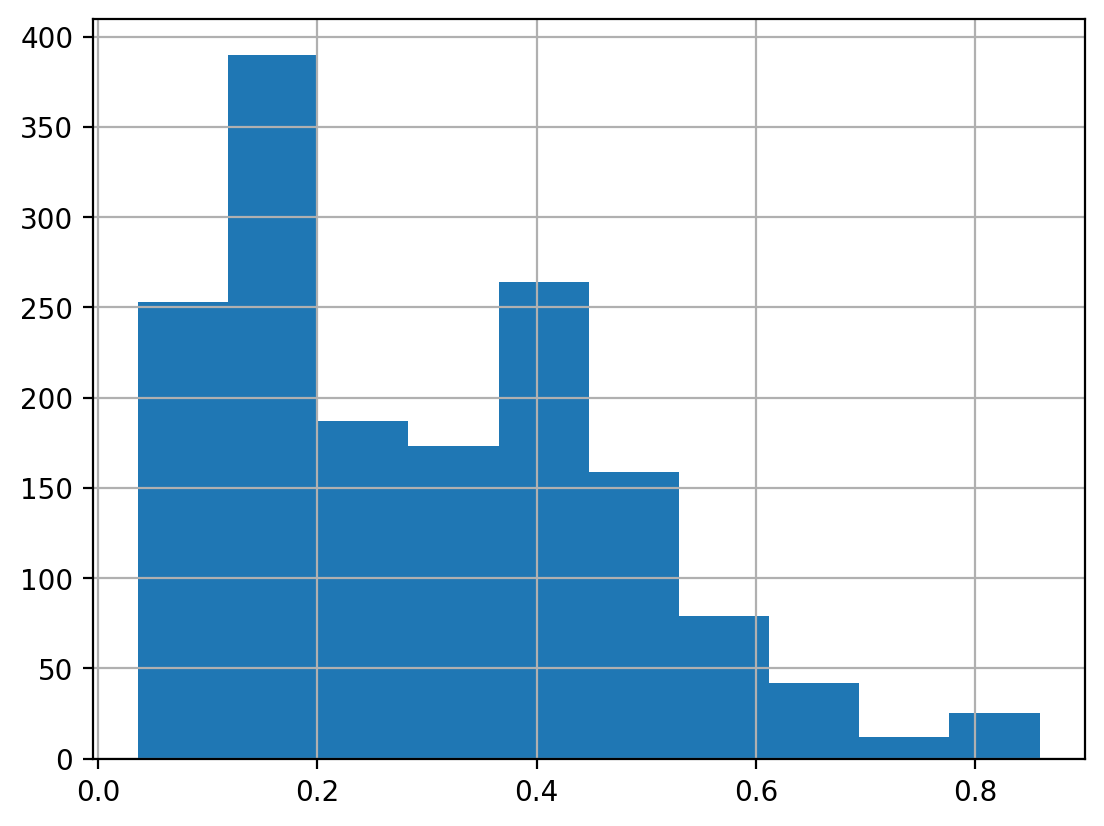

In [25]:
en_df.density.hist()

In [3]:
ex_df = pd.read_csv("../outputs/data_exit_regressions_1100.csv", sep=";")

<Axes: >

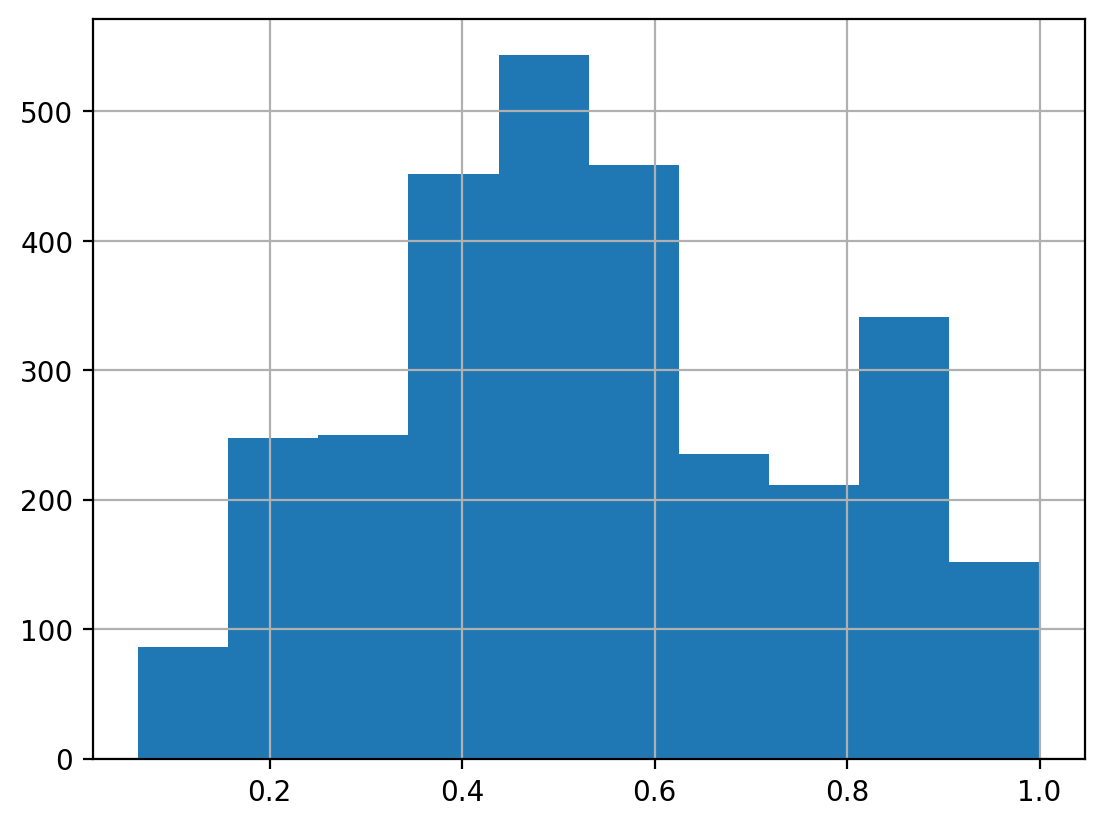

In [5]:
ex_df.density.hist()

In [36]:
#en_df[(en_df["entry01"]==1) & (en_df["density"]>0.3) & (en_df["iso2_code"]=="US")]
ex_df[(ex_df["exit01"]==1) & (ex_df["iso2_code"]=="CN")]

,iso2_code,language,exit01,consider00,pci,ubiquity,rca01,density
569,CN,PureBasic,1,0,2.226369,12.0,0.0,0.436045


In [17]:
ex_df[(ex_df["exit01"]==1) & (ex_df["language"]=="C++")]

,iso2_code,language,exit01,consider00,pci,ubiquity,rca01,density
355,CA,C++,1,0,1.185717,36.0,0.0,0.791143
1999,NL,C++,1,0,1.185717,36.0,0.0,0.821451


**Figure 1 -- ECI(software, trade, technology, research) comparison**

In [2]:
# data from code/01_data_prep_complexity.ipynb	
df = pd.read_csv("../outputs/eci_comparisons_2020.csv", sep=";")

# filter for developer counts or missing values
df2 = df[["iso2_code", "software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]]\
    .dropna()\
    .drop_duplicates()\
    .reset_index(drop=True)

R2 0.606 p-value 0.0    software - trade
R2 0.617 p-value 0.0    software - technology
R2 0.517 p-value 0.0    software - research


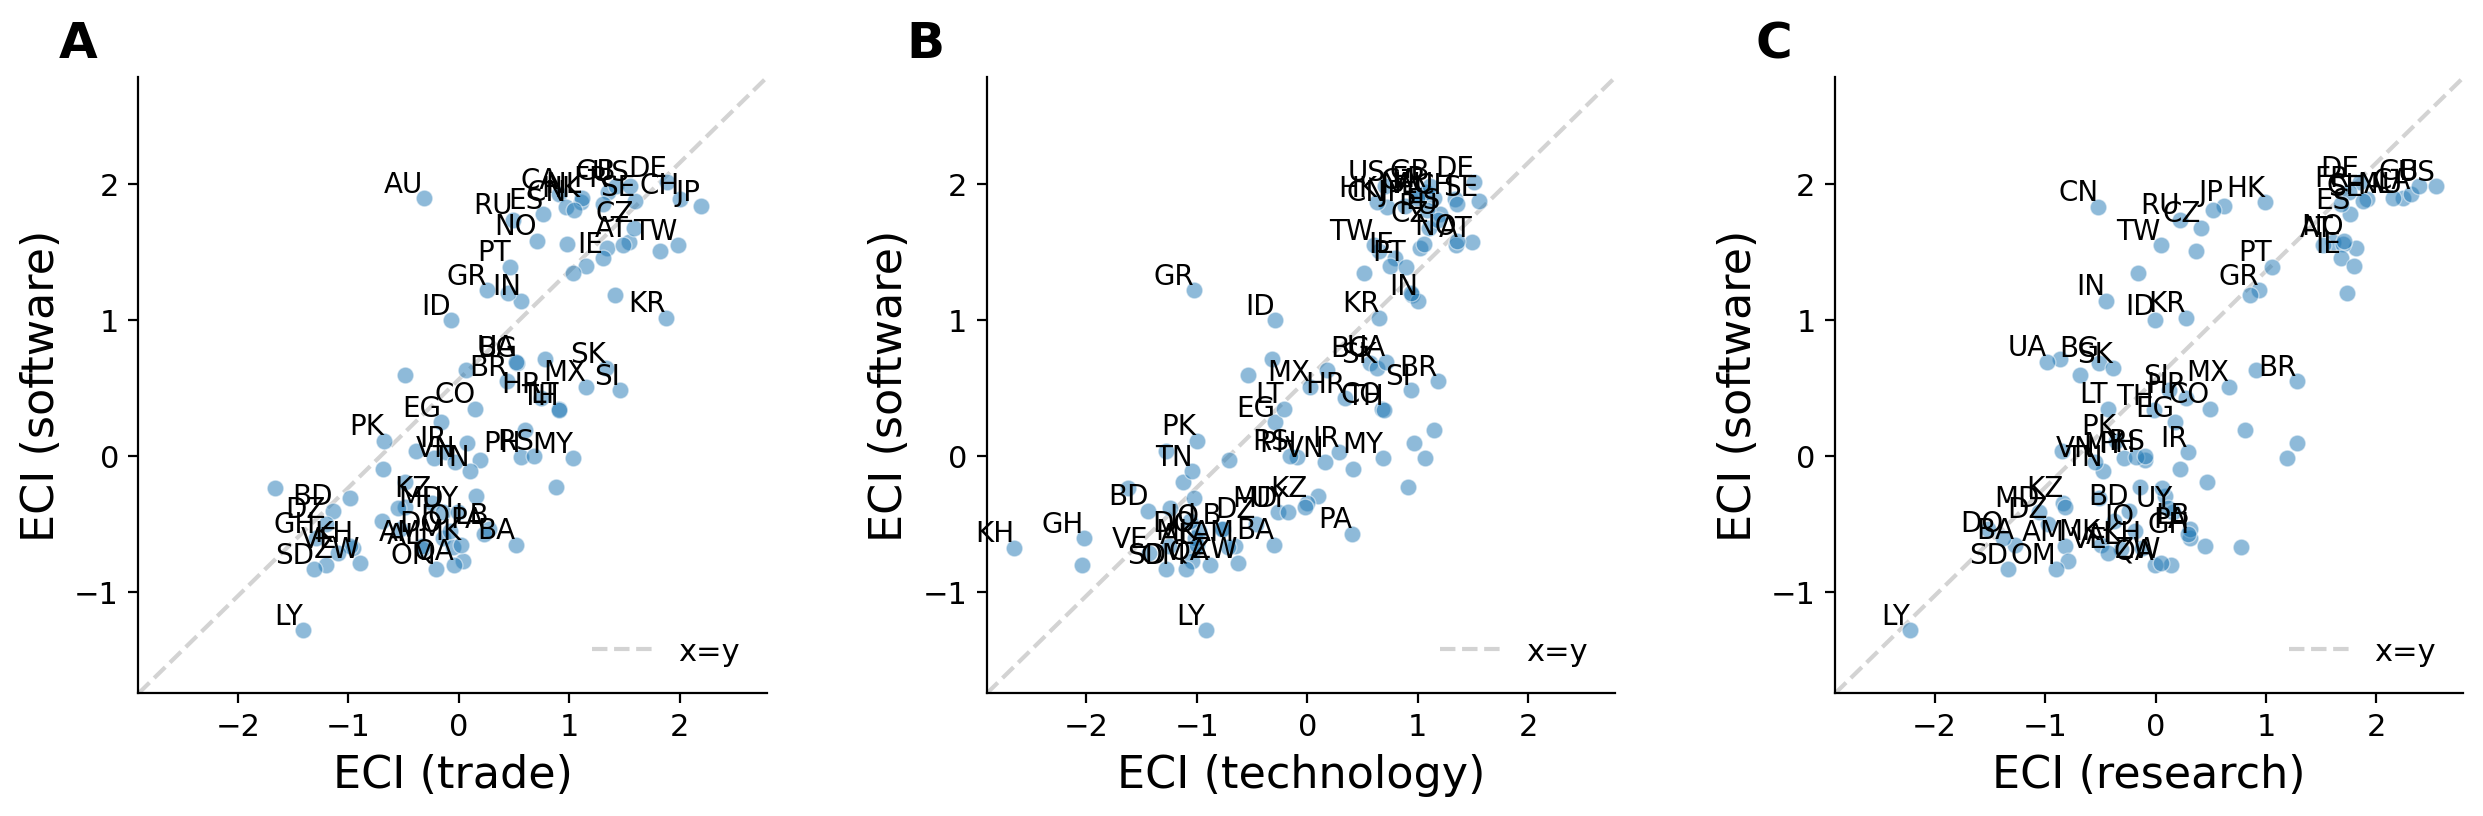

In [3]:
# ECI comparison
fig, ax = plt.subplots(1,3, figsize=(15,4))
plt.subplots_adjust(wspace=0.35)
fontsize = 16


# for axis setting
min_value = df2[["software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]].min().min() - 0.25
max_value = df2[["software_eci_2020", "trade_eci_2020", "tech_eci_2020", "research_eci_2020"]].max().max() + 0.25


# A -- software vs trade
sns.scatterplot(x="trade_eci_2020", y="software_eci_2020", data=df2, alpha=0.5, ax=ax[0])
#sns.regplot(x="trade_eci_2020", y="seci_2020", data=df2, scatter=False, ci=95, ax=ax[0])
slope, intercept, r_value, p_value, std_err = stats.linregress(df2['trade_eci_2020'], df2['software_eci_2020'])
r_squared = r_value ** 2
print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   software - trade")
#ax[0].annotate(f'R2: {r_squared:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
ax[0].set_xlabel("ECI (trade)", size=fontsize)
ax[0].set_ylabel("ECI (software)", size=fontsize)

for i, label in enumerate(df2["iso2_code"]):
    # show labels for every other data point
    if i % 3 != 0:
        ax[0].text(
            df2["trade_eci_2020"][i],
            df2["software_eci_2020"][i],
            label,
            fontsize=fontsize-6,
            ha='right' if i % 3 != 0 else 'left', va='bottom' if i % 3 != 0 else 'top'
        )


# B -- software vs technology
sns.scatterplot(x="tech_eci_2020", y="software_eci_2020", data=df2, alpha=0.5, ax=ax[1])
slope, intercept, r_value, p_value, std_err = stats.linregress(df2["tech_eci_2020"], df2["software_eci_2020"])
r_squared = r_value ** 2
print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   software - technology")
ax[1].set_xlabel("ECI (technology)", size=fontsize)
ax[1].set_ylabel("ECI (software)", size=fontsize)

for i, label in enumerate(df2["iso2_code"]):
    # show labels for every other data point
    if i % 3 != 0:
        ax[1].text(
            df2["tech_eci_2020"][i],
            df2["software_eci_2020"][i],
            label,
            fontsize=fontsize-6,
            ha='right' if i % 3 != 0 else 'left', va='bottom' if i % 3 != 0 else 'top'
        )


# C -- software vs research
sns.scatterplot(x="research_eci_2020", y="software_eci_2020", data=df2, alpha=0.5, ax=ax[2])
slope, intercept, r_value, p_value, std_err = stats.linregress(df2["research_eci_2020"], df2["software_eci_2020"])
r_squared = r_value ** 2
print("R2", round(r_squared, 3), "p-value", round(p_value, 3), "   software - research")
ax[2].set_xlabel("ECI (research)", size=fontsize)
ax[2].set_ylabel("ECI (software)", size=fontsize)

for i, label in enumerate(df2["iso2_code"]):
    # show labels for every other data point
    if i % 3 != 0:
        ax[2].text(
            df2["research_eci_2020"][i],
            df2["software_eci_2020"][i],
            label,
            fontsize=fontsize-6,
            ha='right' if i % 3 !=  0 else 'left', va='bottom' if i % 3 != 0 else 'top'
        )


# common axis settings
for p in [0,1,2]:
    ax[p].tick_params("x", labelsize=(fontsize-5))
    ax[p].tick_params("y", labelsize=(fontsize-5))
    ax[p].spines['top'].set_visible(False)
    ax[p].spines['right'].set_visible(False)
    ax[p].set_xlim(min_value, max_value)
    ax[p].set_ylim(-1.75, max_value)
    ax[p].plot(ax[p].get_xlim(), ax[p].get_ylim(), ls="--", c="lightgrey", label="x=y", zorder=0)
    ax[p].legend(loc="lower right", frameon=False, prop={'size': fontsize-5},)


# subplot title
for a, label in zip(ax, ['A','B','C','D']):
    a.annotate(label.upper(), xy=(0,1), xycoords='axes fraction', xytext=(-80,20), textcoords='offset pixels', weight='bold', size=fontsize+2)


# save
plt.savefig(f"../figures/fig01_eci_comparison.png", dpi=300, bbox_inches="tight", facecolor="white")

**Figure 2 -- language space**

In [430]:
from data_prep_functions import *

In [441]:
# Proximity
proximity = pd.read_csv("../outputs/proximity_2020_2023.csv", sep=";")
# Selecting rows where year is 2020
# We use ECI values from 2020 for comparison on most of the figures + we use relatedness for the ENTRY/EXIT regressions from 2020 .. 
proximity = proximity[proximity["year"] == 2020]
space_table = edgelist_cleaning_for_software_space(proximity, key_columns=["language_1", "language_2", "proximity"])
mst_el = maximum_spanning_tree(space_table, key_columns=["language_1", "language_2", "proximity"])
mst_graph = nx.from_pandas_edgelist(mst_el, source="language_1", target="language_2")

n_nodes = mst_graph.number_of_nodes()
n_edges = n_nodes * 2
el = add_edges(mst_el, space_table, nr_edges_to_add=n_edges)

# export final software space edgelist
el.to_csv("../outputs/software_space_edgelist_2020_2021_based.csv", index=False, sep=";")

In [443]:
# Complexity
cdf = pd.read_csv("../outputs/eci_software_2020_2023.csv", sep=";")
cdf = cdf[cdf["year"] == 2020]

In [494]:
posh_list = [
    "Stata",
    "Julia",
    #"Mathematica",
    "GAP",
    "Elm",
    "Erlang",
    "OCaml",
    "VBA",
    "Fortran",
    "Cuda",
    "Pascal",
    "sed",
    "Perl",
    "Ruby",
    "awk",
    #"MATLAB",
    "R",
    "C",
    "C++",
    "Python",
    "Java",
    "FreeMarker",
    "Typescript",
    "HTML",
    #"CSS",
    "C#",
    "Swift",
    "Kotlin",
    "UnrealScript",
    "Lisp",
    "LLVM",
    #"Brainfuck",
    "CoffeeScript",
    "Prolog",
    #"F#",
    "Scheme",
    #"PowerShell",
    "Jupyter Notebook",
    "Racket",
    #"Game Maker Language",
    "HyPhy",
    "OpenSCAD",
    "Bicep"
]

In [504]:
def software_space_of_country(el, complexity_table, country_code):
    # Filter for the focal country and RCA
    ctable = complexity_table.query("iso2_code == @country_code and rca >= 1")[["language", "rca"]].drop_duplicates()

    # Merge the dataframes more concisely
    cel = el.merge(ctable, left_on="language_1", right_on="language", how="left") \
            .merge(ctable, left_on="language_2", right_on="language", how="left", suffixes=["_i", "_j"])

    # Filter and select relevant columns
    cel_filtered = cel.dropna(subset=["rca_i", "rca_j"])[["language_1", "language_2", "proximity"]]

    return cel_filtered

In [505]:
# common settings
selected_seed=15
fontsize = 18

def custom_graphviz_layout(G, seed=None, **kwargs):
    """graphviz layout does not have a built in seed option"""
    # set the random seed if provided
    if seed is not None:
        random.seed(seed)
    # call the original graphviz_layout function with any additional kwargs
    return nx.drawing.nx_agraph.graphviz_layout(G, **kwargs)

ss_graph = nx.from_pandas_edgelist(el, source="language_1", target="language_2")
pos = custom_graphviz_layout(ss_graph, seed=selected_seed, prog='neato')
pos = {key: (value[0]*1.2, value[1]) for key, value in pos.items()}

#### RCA Graph

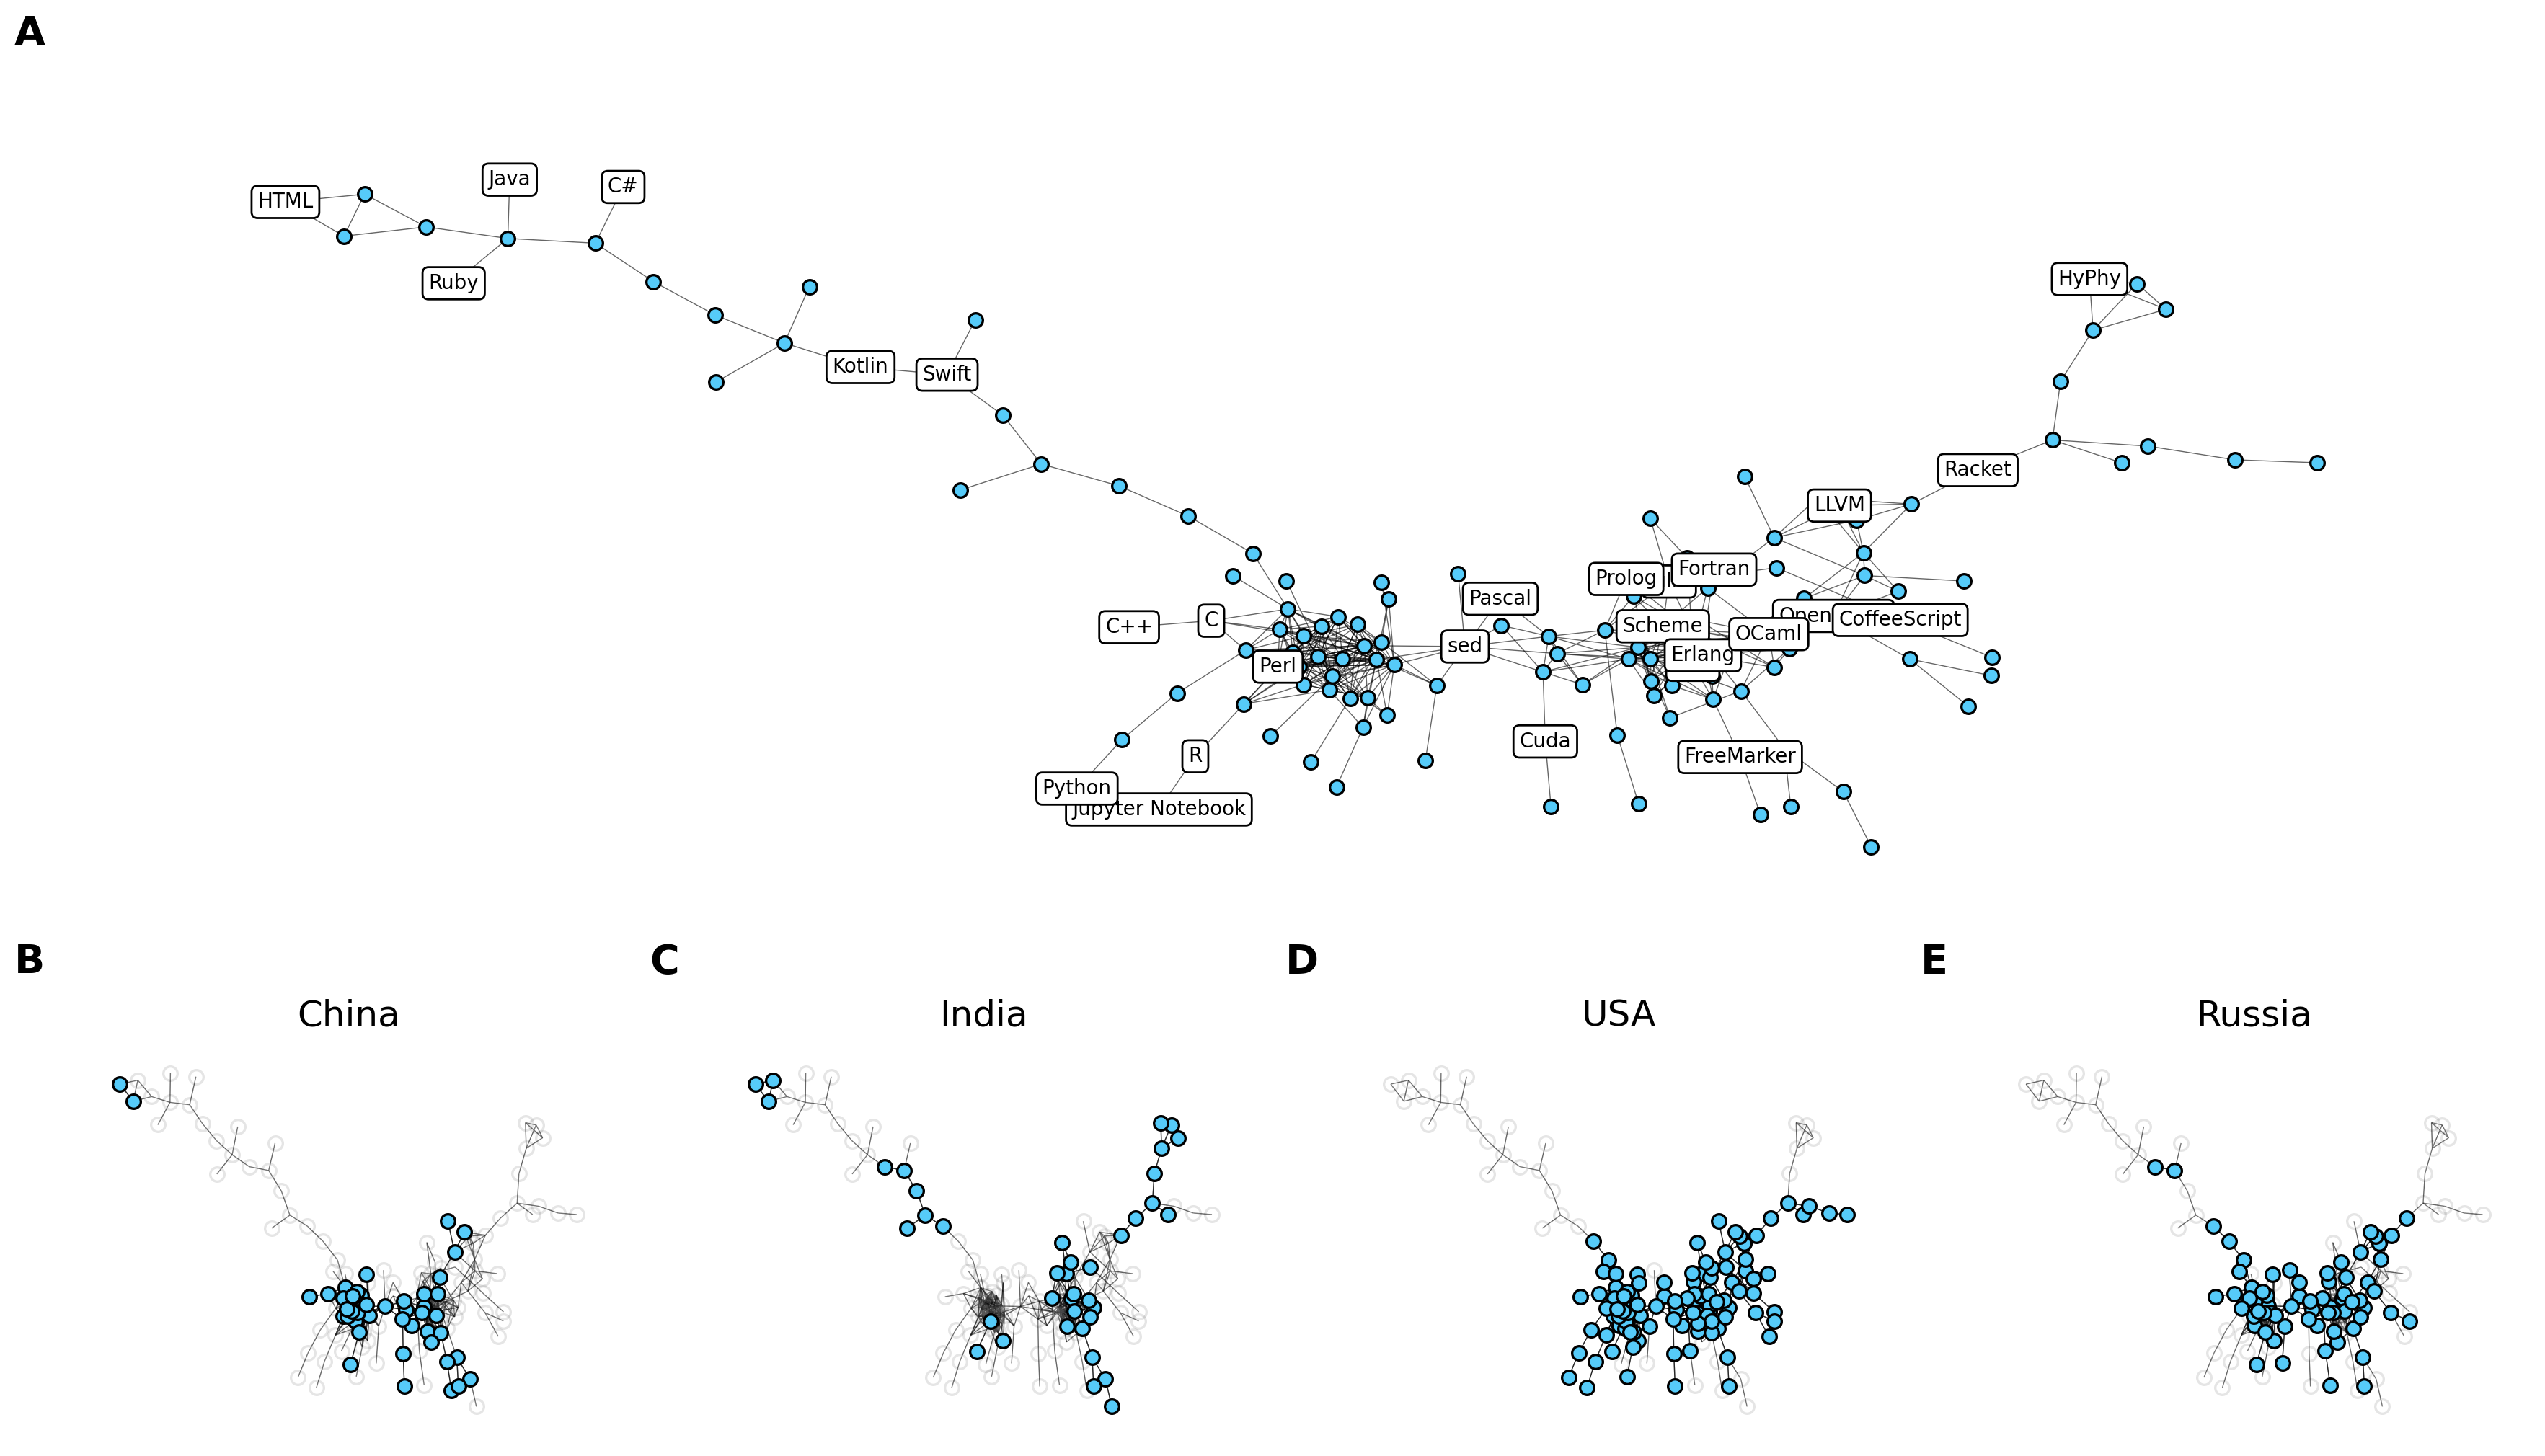

In [574]:
el1 = software_space_of_country(el, cdf, country_code="CN")
graph1 = nx.from_pandas_edgelist(el1, source="language_1", target="language_2")
el2 = software_space_of_country(el, cdf, country_code="IN")
graph2 = nx.from_pandas_edgelist(el2, source="language_1", target="language_2")
el3 = software_space_of_country(el, cdf, country_code="US")
graph3 = nx.from_pandas_edgelist(el3, source="language_1", target="language_2")
el4 = software_space_of_country(el, cdf, country_code="RU")
graph4 = nx.from_pandas_edgelist(el4, source="language_1", target="language_2")

fig = plt.figure(figsize=(22,12))
ax = [0]*8
gs = GridSpec(2, 4, figure=fig, height_ratios=[2.0, 1])
ax[0] = fig.add_subplot(gs[0,0:4])
ax[1] = fig.add_subplot(gs[1,0])
ax[2] = fig.add_subplot(gs[1,1])
ax[3] = fig.add_subplot(gs[1,2])
ax[4] = fig.add_subplot(gs[1,3])
fig.subplots_adjust(hspace=0.2, wspace=0.15)

# A -- full graph
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color="black", width=.5, alpha=.6, ax=ax[0])
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color="#56CBF9", linewidths=1.2, edgecolors='black', ax=ax[0])
nx.draw_networkx_labels(ss_graph.subgraph(posh_list), bbox = dict(facecolor = "white", boxstyle="round"), pos=pos, font_size=fontsize-8, ax=ax[0])
ax[0].axis('off')

# B -- subgraph1
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[1])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[1])
nx.draw_networkx_edges(graph1, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[1])
nx.draw_networkx_nodes(graph1, pos, node_size=50, node_color='#56CBF9',linewidths=1.2, edgecolors='black', ax=ax[1])
ax[1].axis('off')
ax[1].set_title("China", size=fontsize)

# C -- subgraph2
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[2])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[2])
nx.draw_networkx_edges(graph2, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[2])
nx.draw_networkx_nodes(graph2, pos, node_size=50, node_color='#56CBF9',linewidths=1.2, edgecolors='black', ax=ax[2])
ax[2].axis('off')
ax[2].set_title("India", size=fontsize)

# D -- subgraph3
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[3])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[3])
nx.draw_networkx_edges(graph3, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[3])
nx.draw_networkx_nodes(graph3, pos, node_size=50, node_color='#56CBF9', linewidths=1.2, edgecolors='black', ax=ax[3])
ax[3].axis('off')
ax[3].set_title("USA", size=fontsize)

# D -- subgraph4
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[4])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[4])
nx.draw_networkx_edges(graph4, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[4])
nx.draw_networkx_nodes(graph4, pos, node_size=50, node_color='#56CBF9', linewidths=1.2, edgecolors='black', ax=ax[4])
ax[4].axis('off')
ax[4].set_title("Russia", size=fontsize)

# subplot title
for a, label in zip(ax, ['A','B','C','D','E']):
    a.annotate(label.upper(), xy=(0,1), xycoords='axes fraction', xytext=(-80,90), textcoords='offset pixels', weight='bold', size=fontsize+2)

# save
fig.savefig("../figures/fig02_language_spaces.png", dpi=300, bbox_inches="tight", facecolor="white")

In [507]:
print(ss_graph.number_of_nodes(), " nodes")
print(ss_graph.number_of_edges(), " edges")

139  nodes
416  edges


#### Entry network

In [575]:
entry = pd.read_csv("../outputs/data_entry_regressions_0011.csv", sep=";")
entry[(entry["iso2_code"] == "CZ") & (entry["entry01"] >= 1)]

,iso2_code,language,entry01,consider00,pci,ubiquity,rca01,density
403,CZ,Python,1,0,-0.051569,55.0,1.0,0.506423
405,CZ,Ruby,1,0,-0.804169,56.0,1.0,0.385426


In [511]:
exit = pd.read_csv("../outputs/data_exit_regressions_1100.csv", sep=";")
exit[(exit["iso2_code"] == "RU") & (exit["exit01"] == 1)]

,iso2_code,language,exit01,consider00,pci,ubiquity,rca01,density
2401,RU,ANTLR,1,0,2.336210,17.0,0.0,0.632220
2402,RU,Assembly,1,0,1.963645,32.0,0.0,0.629528
2409,RU,Common Lisp,1,0,2.438868,15.0,0.0,0.621865
2412,RU,Erlang,1,0,2.287610,15.0,0.0,0.633129
2424,RU,Lex,1,0,2.013712,26.0,0.0,0.633932
2425,RU,Liquid,1,0,2.550864,7.0,0.0,0.635898
2426,RU,Lua,1,0,1.916407,29.0,0.0,0.622306
2427,RU,M4,1,0,2.141110,30.0,0.0,0.625389
2432,RU,NSIS,1,0,2.458080,18.0,0.0,0.638989
2433,RU,PLSQL,1,0,1.979992,25.0,0.0,0.630639


#### Entry/Exit Graph

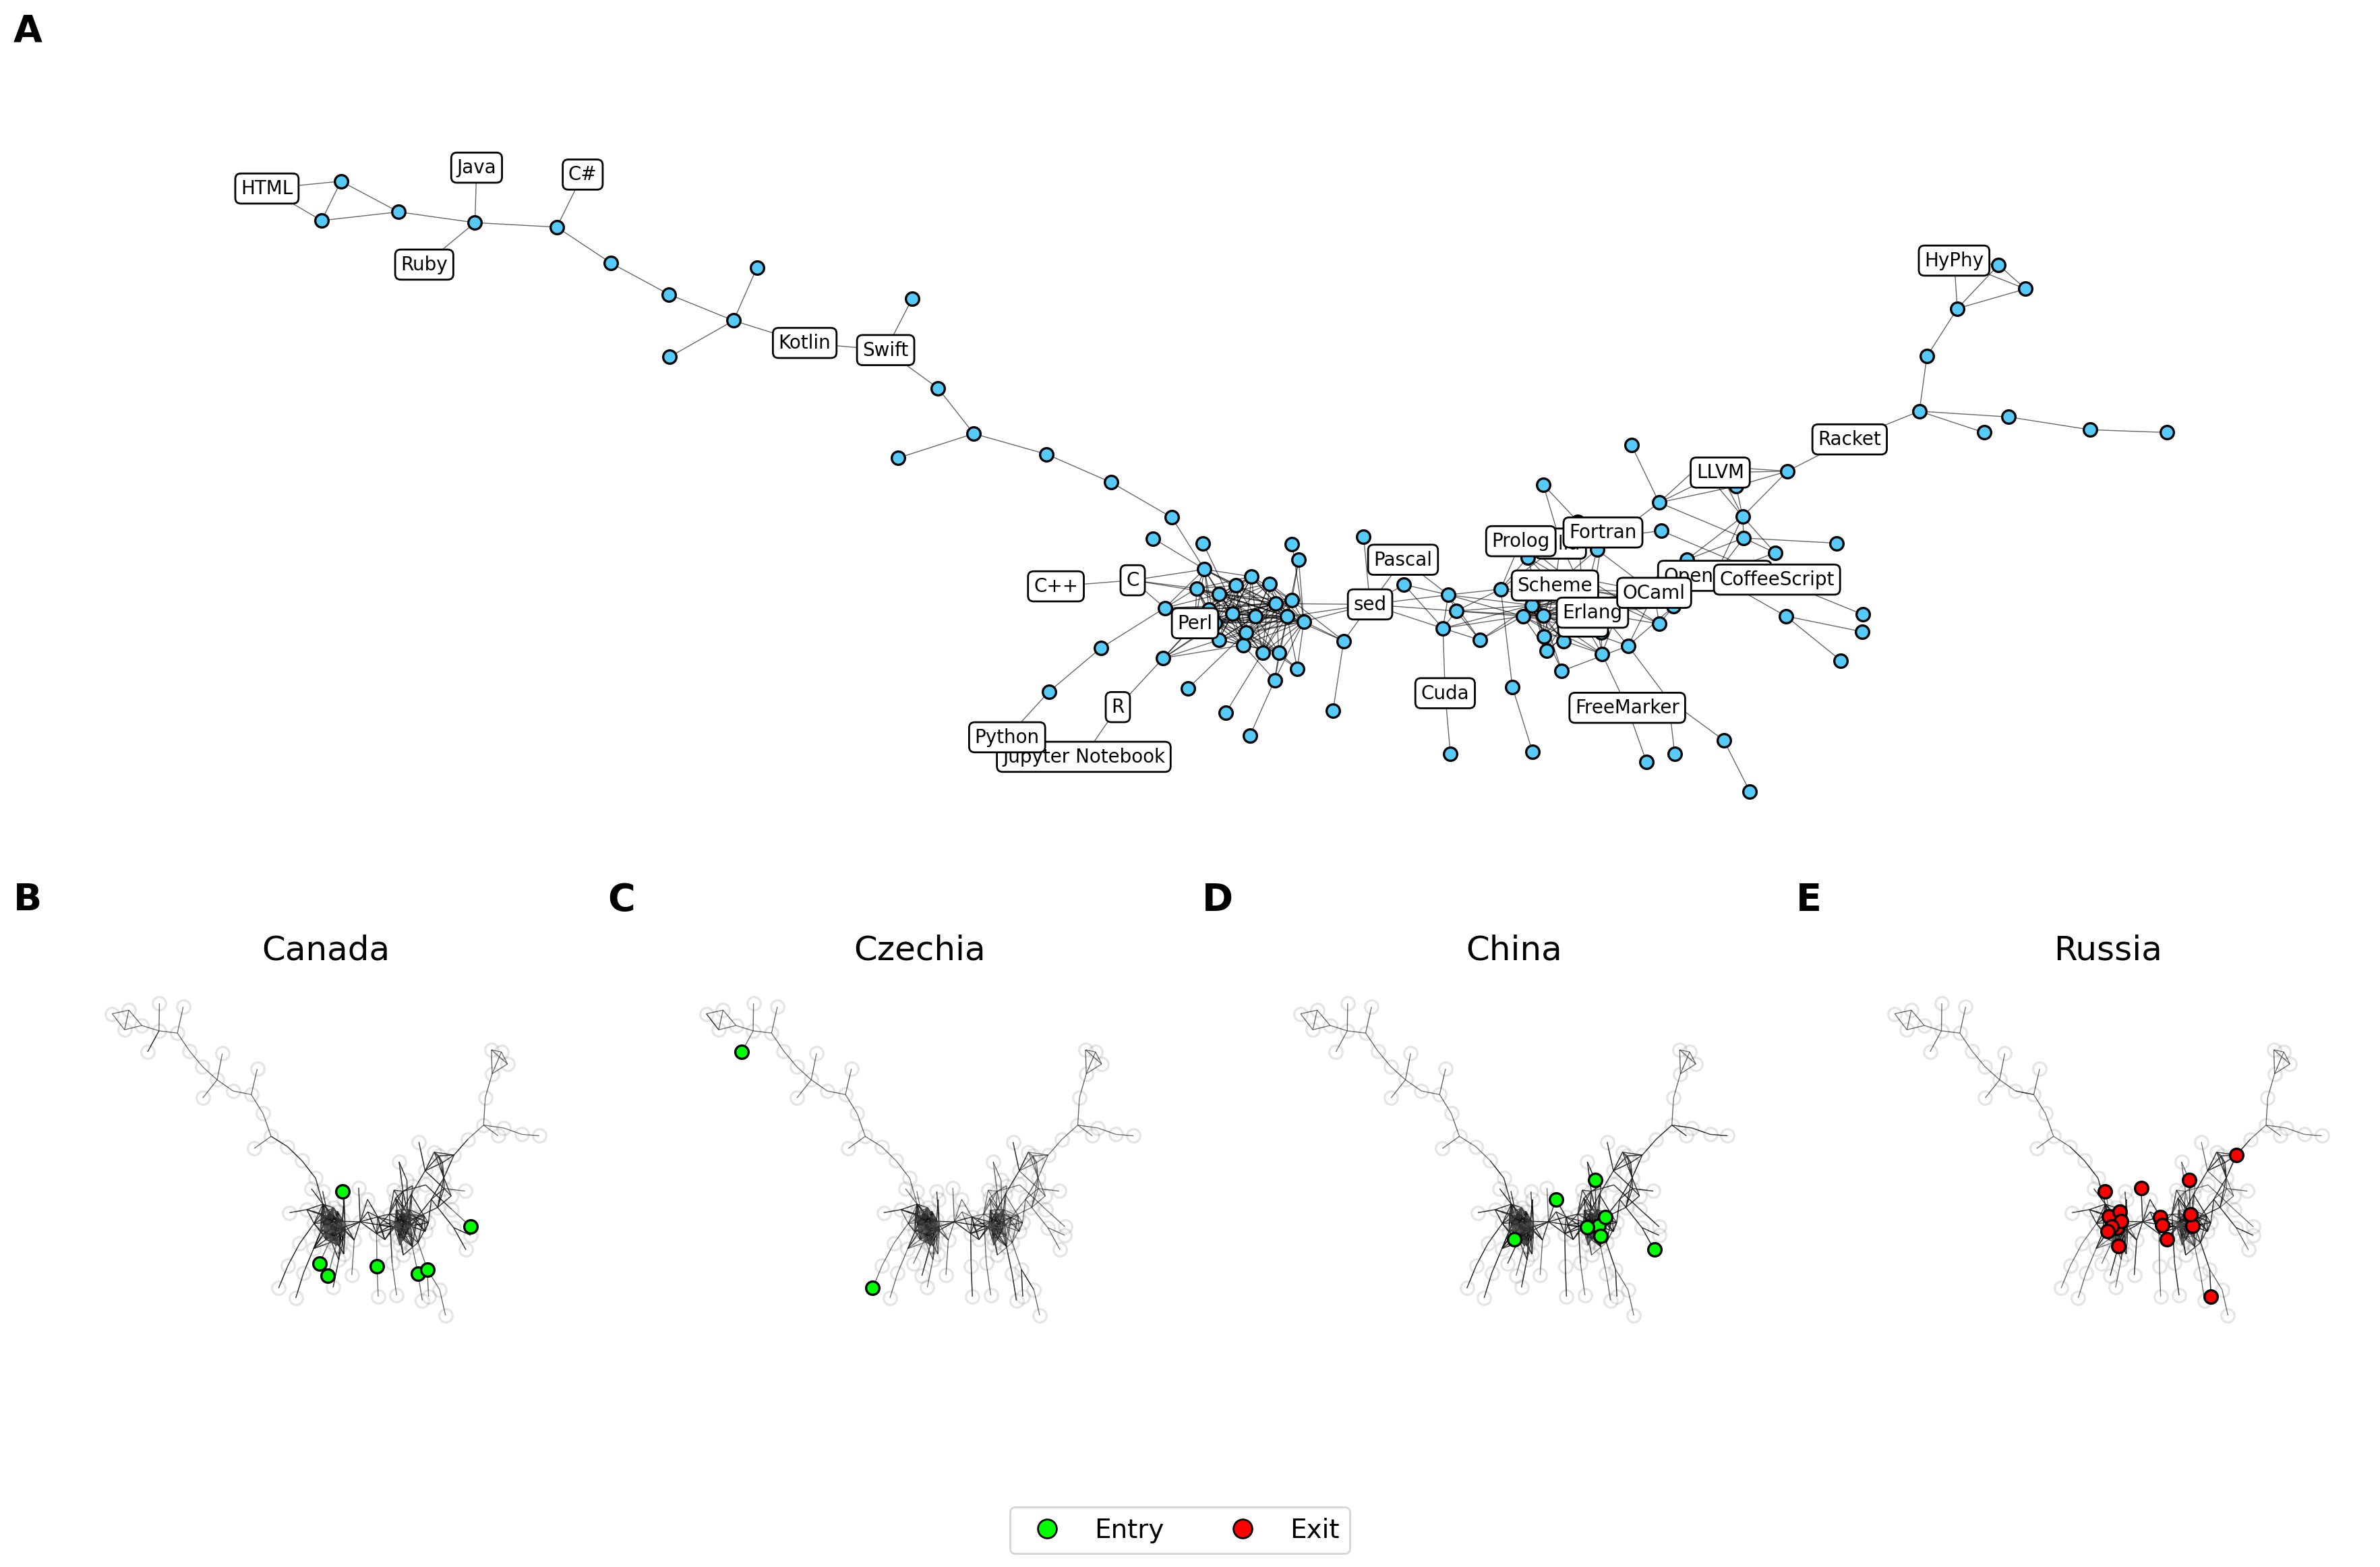

In [570]:
el1 = software_space_of_country(el, cdf, country_code="CA")
graph1 = nx.from_pandas_edgelist(el1, source="language_1", target="language_2")
el2 = software_space_of_country(el, cdf, country_code="CN")
graph2 = nx.from_pandas_edgelist(el2, source="language_1", target="language_2")
el3 = software_space_of_country(el, cdf, country_code="US")
graph3 = nx.from_pandas_edgelist(el3, source="language_1", target="language_2")
el4 = software_space_of_country(el, cdf, country_code="RU")
graph4 = nx.from_pandas_edgelist(el4, source="language_1", target="language_2")

canada_entry = list(entry[(entry["iso2_code"] == "CA") & (entry["entry01"] >= 1)]["language"])
czechia_entry = list(entry[(entry["iso2_code"] == "CZ") & (entry["entry01"] >= 1)]["language"])
china_entry = list(entry[(entry["iso2_code"] == "CN") & (entry["entry01"] >= 1)]["language"])
russia_exit = list(exit[(exit["iso2_code"] == "RU") & (exit["exit01"] >= 1)]["language"])

fig = plt.figure(figsize=(22,12))
ax = [0]*8
gs = GridSpec(2, 4, figure=fig, height_ratios=[2.0, 1])
ax[0] = fig.add_subplot(gs[0,0:4])
ax[1] = fig.add_subplot(gs[1,0])
ax[2] = fig.add_subplot(gs[1,1])
ax[3] = fig.add_subplot(gs[1,2])
ax[4] = fig.add_subplot(gs[1,3])
fig.subplots_adjust(hspace=0.2, wspace=0.15)

# A -- full graph
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color="black", width=.5, alpha=.6, ax=ax[0])
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color="#56CBF9", linewidths=1.2, edgecolors='black', ax=ax[0])
nx.draw_networkx_labels(ss_graph.subgraph(posh_list), bbox = dict(facecolor = "white", boxstyle="round"), pos=pos, font_size=fontsize-8, ax=ax[0])
ax[0].axis('off')

# A -- subgraph1
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[1])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[1])
nx.draw_networkx_edges(graph1, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[1])
nx.draw_networkx_nodes(ss_graph.subgraph(canada_entry), pos, node_size=50, node_color="#00FF00",linewidths=1.2, edgecolors='black', ax=ax[1])
ax[1].axis('off')
ax[1].set_title("Canada", size=fontsize)

# B -- subgraph2
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[2])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[2])
nx.draw_networkx_edges(graph2, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[2])
nx.draw_networkx_nodes(ss_graph.subgraph(czechia_entry), pos, node_size=50, node_color="#00FF00",linewidths=1.2, edgecolors='black', ax=ax[2])
ax[2].axis('off')
ax[2].set_title("Czechia", size=fontsize)

# C -- subgraph3
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[3])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[3])
nx.draw_networkx_edges(graph3, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[3])
nx.draw_networkx_nodes(ss_graph.subgraph(china_entry), pos, node_size=50, node_color="#00FF00",linewidths=1.2, edgecolors='black', ax=ax[3])
ax[3].axis('off')
ax[3].set_title("China", size=fontsize)

# D -- subgraph4
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color='white', linewidths=1.2, alpha=.1, edgecolors='black', ax=ax[4])
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[4])
nx.draw_networkx_edges(graph4, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax[4])
nx.draw_networkx_nodes(ss_graph.subgraph(russia_exit), pos, node_size=50, node_color="#FF0000",linewidths=1.2, edgecolors='black', ax=ax[4])
ax[4].axis('off')
ax[4].set_title("Russia", size=fontsize)

# subplot title
for a, label in zip(ax, ['A','B','C','D','E']):
    a.annotate(label.upper(), xy=(0,1), xycoords='axes fraction', xytext=(-80,90), textcoords='offset pixels', weight='bold', size=fontsize+2)

# Create custom legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Entry', markerfacecolor='#00FF00', markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Exit', markerfacecolor='#FF0000', markersize=10, markeredgecolor='black')
]

# Add legend below the subplots
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.025), ncol=2, fontsize=14)

# save
fig.savefig("../figures/fig02_language_spaces_entry_exit.png", dpi=300, bbox_inches="tight", facecolor="white")

#### Full network plot

(-165.81703500000003, 2177.550035, -86.349, 1116.1490000000001)

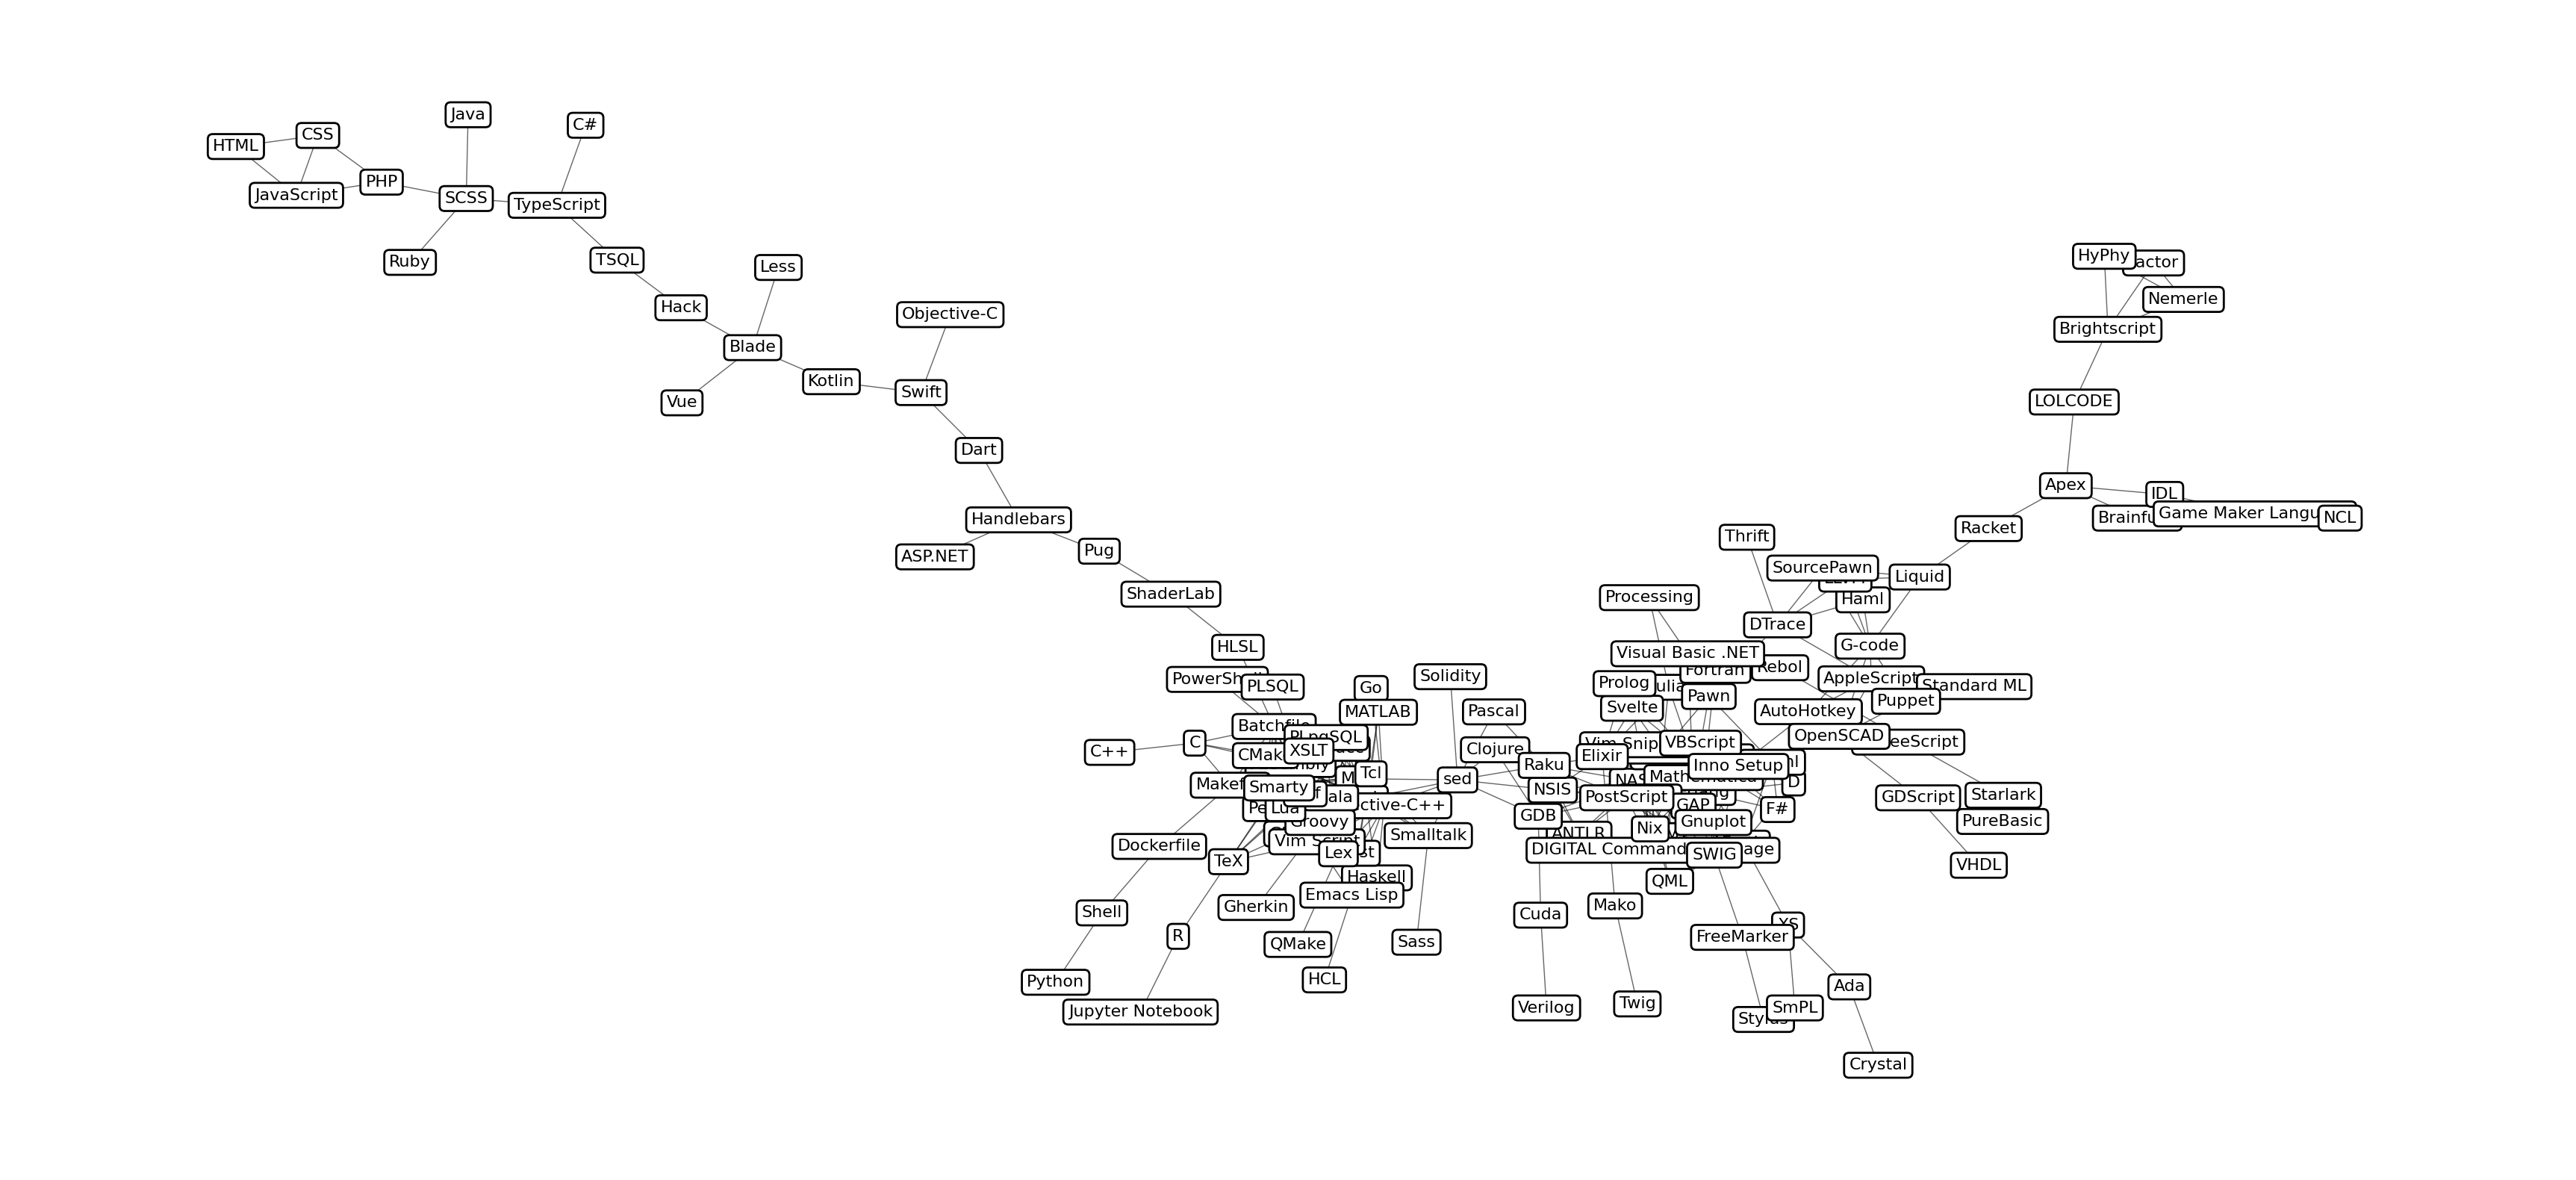

In [464]:
ss_graph = nx.from_pandas_edgelist(el, source="language_1", target="language_2")
fig, ax = plt.subplots(1,1, figsize=(22,10))
pos = nx.drawing.nx_agraph.graphviz_layout(ss_graph, prog='neato')
nx.draw_networkx_edges(ss_graph, pos=pos, edge_color='black', width=.5, alpha=.6, ax=ax)
nx.draw_networkx_nodes(ss_graph, pos, node_size=50, node_color='#56CBF9',linewidths=1.2, edgecolors='black', ax=ax)
nx.draw_networkx_labels(ss_graph, bbox = dict(facecolor = "white",boxstyle='round'), pos=pos,font_size=8, ax=ax)
ax.axis('off')

In [517]:
pd.set_option('display.max_rows', 500)
cdf[["language", "pci"]].drop_duplicates().sort_values(by="pci").head(200)

,language,pci
47,HTML,-1.286411
16,CSS,-1.203895
56,JavaScript,-1.068250
103,Ruby,-0.804169
82,PHP,-0.711708
55,Java,-0.651737
105,SCSS,-0.649498
25,Dart,-0.636643
134,Vue,-0.590525
9,Blade,-0.472338
